In [14]:
#see if thru is effective with different weight initialization
#study thru architecure 1: parallel
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import time

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784
hidden_size = 500
num_classes = 10
batch_size = 100
learning_rate = 0.001
num_workers=0

num_epochs = 5

transform = transforms.ToTensor()
train_data = datasets.MNIST(root='/Users/dongcui/github/visualising-cnns/data', train=True,
                                   download=False, transform=transform)
test_data = datasets.MNIST(root='/Users/dongcui/github/visualising-cnns/data', train=False,
                                  download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle = True)

In [15]:
def relu_my(A, d):
    return torch.max(A, torch.ones_like(A) * d) - d

def relu_min(A, d):
    return torch.min(A, torch.ones_like(A) * d) - d 


In [16]:
class ReLU_min(nn.Module):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:
        SiLU(x) = x * sigmoid(x)
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    References:
        -  Related paper:
        https://arxiv.org/pdf/1606.08415.pdf
    Examples:
        >>> m = silu()
        >>> input = torch.randn(2)
        >>> output = m(input)
    '''
    def __init__(self, threshold):
        '''
        Init method.
        '''
        super().__init__() # init the base class
        self.threshold=threshold

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return relu_min(input, self.threshold)
    
    
class ReLU_my(nn.Module):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:
        SiLU(x) = x * sigmoid(x)
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    References:
        -  Related paper:
        https://arxiv.org/pdf/1606.08415.pdf
    Examples:
        >>> m = silu()
        >>> input = torch.randn(2)
        >>> output = m(input)
    '''
    def __init__(self, threshold):
        '''
        Init method.
        '''
        super().__init__() # init the base class
        self.threshold=threshold

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return relu_my(input, self.threshold)




Epoch [1/5], Step [100/600], Loss: 32.7361
Epoch [1/5], Step [200/600], Loss: 17.9352
Epoch [1/5], Step [300/600], Loss: 16.3820
Epoch [1/5], Step [400/600], Loss: 16.5854
Epoch [1/5], Step [500/600], Loss: 14.1765
Epoch [1/5], Step [600/600], Loss: 14.1162
Epoch [2/5], Step [100/600], Loss: 12.3405
Epoch [2/5], Step [200/600], Loss: 6.2081
Epoch [2/5], Step [300/600], Loss: 11.2585
Epoch [2/5], Step [400/600], Loss: 4.4774
Epoch [2/5], Step [500/600], Loss: 14.2656
Epoch [2/5], Step [600/600], Loss: 8.5622
Epoch [3/5], Step [100/600], Loss: 5.4734
Epoch [3/5], Step [200/600], Loss: 1.8454
Epoch [3/5], Step [300/600], Loss: 2.4444
Epoch [3/5], Step [400/600], Loss: 5.4954
Epoch [3/5], Step [500/600], Loss: 3.9322
Epoch [3/5], Step [600/600], Loss: 3.0456
Epoch [4/5], Step [100/600], Loss: 6.5554
Epoch [4/5], Step [200/600], Loss: 8.0792
Epoch [4/5], Step [300/600], Loss: 3.5744
Epoch [4/5], Step [400/600], Loss: 4.8771
Epoch [4/5], Step [500/600], Loss: 2.0014
Epoch [4/5], Step [600/60

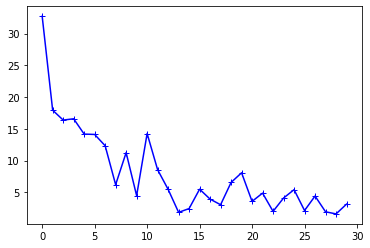

7.97057363986969
Accuracy of the network on the 10000 test images: 92.86 %


In [17]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1)#93.58. relu is 93%
#         m.weight.data.normal_(-1, 1)#89% accuracy! while for relu with same initialization it is only 11%
    #so this means thru is more robust to initialization. 

class ThresholdingParallel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ThresholdingParallel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        
        self.relu2 = ReLU_my(0.1)
        self.minlu = ReLU_min(0.1)
        
        self.fc2 = nn.Linear(hidden_size * 2, num_classes)  
    
    def forward(self, x):
        out = x
        out = self.fc1(out)

        #add thresholding to relu outputs
        out1 = self.minlu(out)
        out2 = self.relu2(out)
        
        out = torch.cat((out1, out2), dim=1)
    
        out = self.fc2(out)
        return out #, out1, out2  

model = ThresholdingParallel(input_size, hidden_size, num_classes).to(device)
model.apply(weights_init)

#visualzing graphs
# writer=SummaryWriter('runs/thresholding')
# dataiter=iter(train_loader)
# images, labels = dataiter.next()
# grid = torchvision.utils.make_grid(images)
# #writer.add_image('images', grid, 0)

# # images = images.reshape(-1, 28*28).to(device)
# dummy_input = torch.zeros(1, 28*28),
# writer.add_graph(model, dummy_input)
# writer.close()

start = time.time()
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
total_step = len(train_loader)
losses=[]
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            losses.append(loss.item())
            

print('elapsed: ', time.time()-start)
plt.plot(losses, '-b+')
plt.show()
print(np.mean(losses))


# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
labels_wrong = []
pred_wrong = []
img_wrong = []
with torch.no_grad():
    correct = 0
    total = 0
    for img, labels in test_loader:
#         print(img.shape)
        images = img.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        wrong_preds = (predicted != labels).numpy()
        wrong_index = []
        for (i, wrong) in enumerate(wrong_preds):
            if wrong:
                wrong_index.append(i) 
        if len(wrong_index) > 0:
            img_reshaped = img[wrong_index].numpy()[:,0,:,:]
            for img_w in range(img_reshaped.shape[0]):
                img_wrong.append(img_reshaped[img_w])
            labels_wrong  += (labels[wrong_index].numpy().tolist())
            pred_wrong += (predicted[wrong_index].numpy().tolist())
#     print(img_wrong)
#     print('img_wrong.shape', img_wrong[0].shape)
#     print('lables_wrong =', labels_wrong)
#     print('predictions wrong are:', pred_wrong)
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

#show wrong images:
# print(len(img_wrong), ', ', len(labels_wrong), ', ', len(pred_wrong))
# for i in range(len(img_wrong)):
#     plt.imshow(img_wrong[i])
#     print('labels_wrong[i]:', labels_wrong[i])
#     print('pred_wrong[i]', pred_wrong[i])
#     plt.pause(1)

# Save the model checkpoint
# torch.save(model.state_dict(), 'model.ckpt')

In [ ]:
print('layer 1:')
w_fc1 = list(model.fc1.parameters())
print(w_fc1)

print('layer 2:')
w_fc2 = list(model.fc2.parameters())
print(w_fc2)

#check dead neurons
images, labels = dataiter.next()
images = images.reshape(-1, 28*28).to(device)
# print(images.shape)
A1 = images[:1]
# print(A1.shape)
output, output_relu, output_minlu = model(A1)

output_relu = output_relu.T.detach()
# print(output_relu.shape)
# plt.plot(output_relu.numpy(), '-b+')
# plt.show()
print('np.count_nonzero(output_relu)=', np.count_nonzero(output_relu))
# print('sparsity', 1- np.count_nonzero(output_relu)/ (output_relu.shape[0] * output_relu.shape[1]))

output_minlu = output_minlu.T.detach()
print(output_minlu.shape)
plt.plot(output_minlu.numpy(), '-b+')
print('np.count_nonzero(output_minlu)=', np.count_nonzero(output_minlu))
# plt.show()

#either one of minlu and relu must be activated. ignore zero features. 
assert (np.count_nonzero(output_minlu) + np.count_nonzero(output_relu) == hidden_size)